## Exploration of wildfire data

Dataset: 1.88 million US wildfires: https://www.kaggle.com/rtatman/188-million-us-wildfires
24 years (1992 to 2015) of wildfire data

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import datetime

plt.rcParams.update({'font.size': 15})

In [43]:
#First get information about the database
path_and_file = 'data\\dataset_wildfires\\FPA_FOD_20170508.sqlite'

def get_table_names(connection):
    cursor = connection.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    table_list = cursor.fetchall()
    return [item[0] for item in table_list]

db = sqlite3.connect(path_and_file)
table_names = get_table_names(db)
for table_name in table_names:
    print(table_name)

spatial_ref_sys
spatialite_history
sqlite_sequence
geometry_columns
spatial_ref_sys_aux
views_geometry_columns
virts_geometry_columns
geometry_columns_statistics
views_geometry_columns_statistics
virts_geometry_columns_statistics
geometry_columns_field_infos
views_geometry_columns_field_infos
virts_geometry_columns_field_infos
geometry_columns_time
geometry_columns_auth
views_geometry_columns_auth
virts_geometry_columns_auth
sql_statements_log
SpatialIndex
ElementaryGeometries
KNN
Fires
idx_Fires_Shape
idx_Fires_Shape_node
idx_Fires_Shape_rowid
idx_Fires_Shape_parent
NWCG_UnitIDActive_20170109


In [3]:
# Main data is in the Fires table
df = pd.read_sql_query('select * from Fires', db)
df.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 39 columns):
OBJECTID                      1880465 non-null int64
FOD_ID                        1880465 non-null int64
FPA_ID                        1880465 non-null object
SOURCE_SYSTEM_TYPE            1880465 non-null object
SOURCE_SYSTEM                 1880465 non-null object
NWCG_REPORTING_AGENCY         1880465 non-null object
NWCG_REPORTING_UNIT_ID        1880465 non-null object
NWCG_REPORTING_UNIT_NAME      1880465 non-null object
SOURCE_REPORTING_UNIT         1880465 non-null object
SOURCE_REPORTING_UNIT_NAME    1880465 non-null object
LOCAL_FIRE_REPORT_ID          421179 non-null object
LOCAL_INCIDENT_ID             1059644 non-null object
FIRE_CODE                     324829 non-null object
FIRE_NAME                     923276 non-null object
ICS_209_INCIDENT_NUMBER       25717 non-null object
ICS_209_NAME                  25717 non-null object
MTBS_ID                       11

In [4]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


### Visualizing geographic distribution of fires
Note that because I'm using latitude and longitude to plot, I'm basically making a equirectangular projection;
this will underestimate density the farther away from the equator a location is

In [5]:
# Previously saved a DataFrame with latitude and longitude of the US cities with the largest populations
# (Source was https://simplemaps.com/data/us-cities, downloaded 11/20/2019)
file = open('data/big_cities.pickle', 'rb')
cities = pickle.load(file)
file.close()
cities.head()

,city,population,lat,lng
106,Seattle,3643765.0,47.6211,-122.3244
697,Washington,5289420.0,38.9047,-77.0163
2065,Tampa,2804240.0,27.9942,-82.4451
2882,Miami,6381966.0,25.7839,-80.2102
4464,Dallas,5733259.0,32.7936,-96.7662


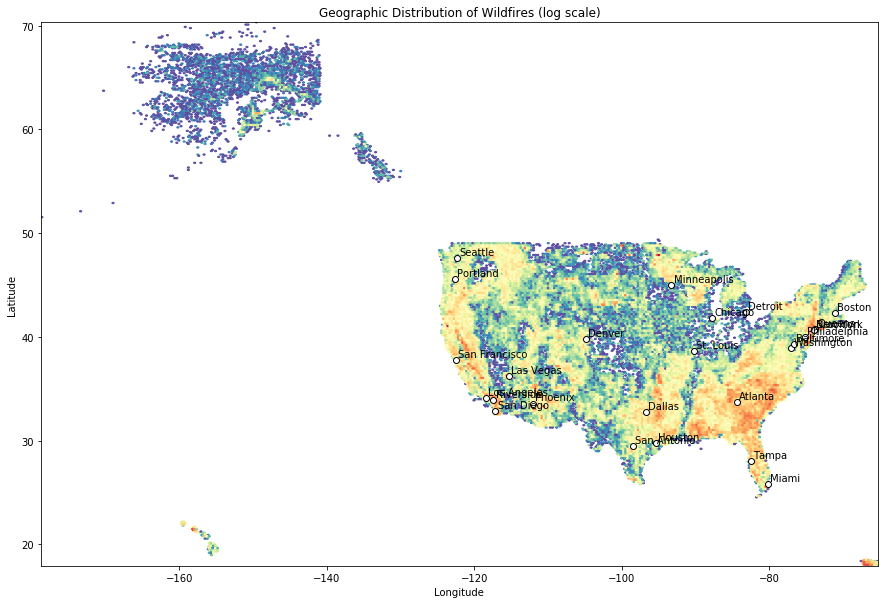

In [6]:
# Visualize latitude and longitude of all fires
_ = plt.figure(figsize = (15,10))
_ = plt.hexbin(df.LONGITUDE, df.LATITUDE, gridsize = 400, bins = 'log', mincnt = 1, cmap = 'Spectral_r')
#_ = plt.colorbar()
for name, latitude, longitude in zip(cities.city, cities.lat, cities.lng):
    plt.scatter(longitude, latitude, marker = 'o', edgecolor = 'k', c = 'w')
    plt.text(longitude+0.3, latitude+0.3, name)
_ = plt.xlabel('Longitude')
_ = plt.ylabel('Latitude')
_ = plt.title('Geographic Distribution of Wildfires (log scale)')

California has a high density of fires.  Georgia also looks particularly flammable; this is presumably because Georgia has a lot of trees.

In [7]:
years = sorted(df.FIRE_YEAR.unique())
len(years)

24

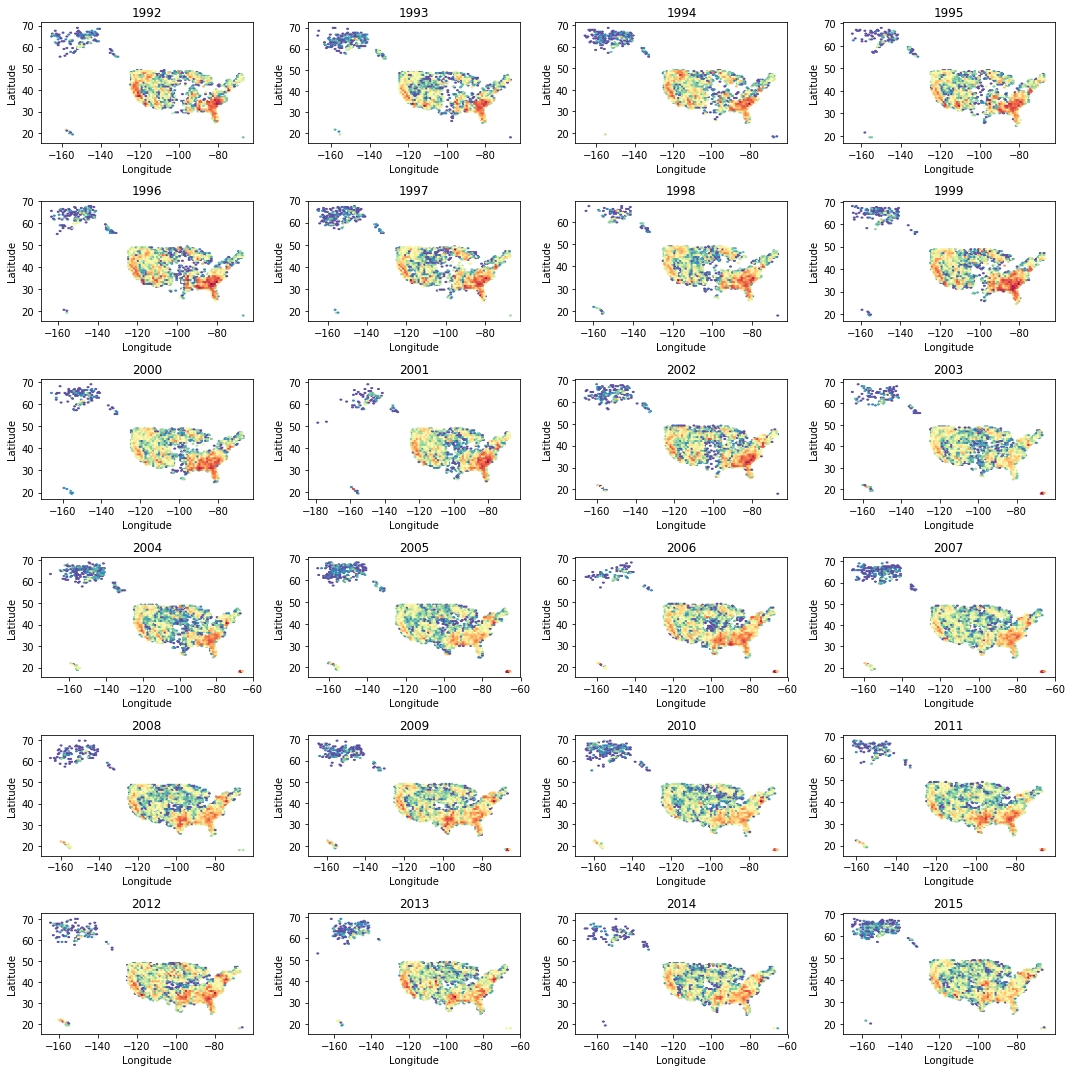

In [8]:
# Do the same maps, but divided up by year
_ = plt.figure(figsize = (15,15))
for idx, year in enumerate(years):
    _ = plt.subplot(6,4,idx+1)
    _ = plt.hexbin(df.LONGITUDE[df.FIRE_YEAR == year], df.LATITUDE[df.FIRE_YEAR == year], 
                   gridsize = 100, bins = 'log', mincnt = 1, cmap = 'Spectral_r')
    _ = plt.xlabel('Longitude')
    _ = plt.ylabel('Latitude')
    _ = plt.title(year)
_ = plt.tight_layout()

### Fire size distributions

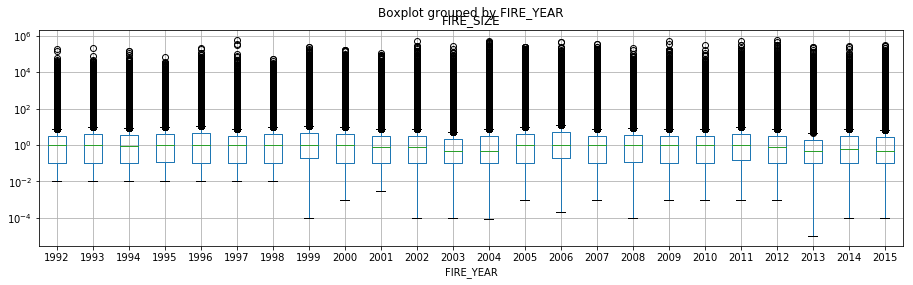

In [9]:
# Look for year-on-year differences in fire size
_ = df.boxplot(column = 'FIRE_SIZE', by = 'FIRE_YEAR', figsize = (15, 4))
_ = plt.yscale('log')

This graph isn't very helpful because small fires so vastly outnumber large ones that I had to use a log scale to see the boxes at all.

In [10]:
#Look by state at fire size categories
df.pivot_table(index = 'STATE', columns = 'FIRE_SIZE_CLASS', values = 'OBJECTID', aggfunc = 'count').sort_values('G', ascending = False)

FIRE_SIZE_CLASS,A,B,C,D,E,F,G
STATE,,,,,,,
AK,6622.0,3386.0,1045.0,349.0,378.0,413.0,650.0
CA,98309.0,76942.0,9825.0,2137.0,1187.0,756.0,394.0
ID,20706.0,10446.0,2587.0,1062.0,810.0,693.0,394.0
NV,9321.0,4529.0,1505.0,483.0,416.0,407.0,295.0
OR,43495.0,13831.0,2098.0,638.0,417.0,353.0,256.0
TX,18127.0,91843.0,25452.0,3782.0,1781.0,798.0,238.0
NM,17459.0,14108.0,3545.0,927.0,710.0,493.0,236.0
MT,23229.0,13082.0,2650.0,691.0,518.0,374.0,223.0
AZ,42694.0,23052.0,3821.0,839.0,591.0,413.0,176.0


Interestingly, though Alaska has a low frequency of fires over all, it has the most fires in the largest category - perhaps no one is bothering to put them out?

### Time from fire discovery to containment

In [11]:
time_columns = ['FIRE_YEAR','DISCOVERY_DATE','DISCOVERY_DOY','DISCOVERY_TIME','CONT_DATE','CONT_DOY','CONT_TIME']
df[time_columns].head(10)

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,CONT_DATE,CONT_DOY,CONT_TIME
0,2005,2453403.5,33,1300,2453403.5,33.0,1730
1,2004,2453137.5,133,0845,2453137.5,133.0,1530
2,2004,2453156.5,152,1921,2453156.5,152.0,2024
3,2004,2453184.5,180,1600,2453189.5,185.0,1400
4,2004,2453184.5,180,1600,2453189.5,185.0,1200
5,2004,2453186.5,182,1800,2453187.5,183.0,1600
6,2004,2453187.5,183,1800,2453188.5,184.0,1400
7,2005,2453437.5,67,1300,2453437.5,67.0,1600
8,2005,2453444.5,74,1200,2453444.5,74.0,1700
9,2004,2453187.5,183,1800,2453188.5,184.0,1800


In [12]:
print('%0.1f%% of fires have containment day given.' %(100*(1-np.isnan(df.CONT_DATE).sum()/df.DISCOVERY_DATE.count())))

52.6% of fires have containment day given.


In [13]:
# Get conversion formula from numeric date to actual date
jan_1 = df.loc[df.DISCOVERY_DOY == 1]
print('The numerical value for January 1, 1992 is %.1f' %jan_1.groupby('FIRE_YEAR').median().DISCOVERY_DATE.loc[1992])

def calculate_date(date_number):
    if np.isnan(date_number):
        return np.nan
    start_date = datetime.date(1992, 1, 1)
    start_number = 2448622.5
    return start_date + datetime.timedelta(days = (date_number - start_number))

df['DISCOVERY_DATE_dt'] = [calculate_date(d) for d in df.DISCOVERY_DATE]
df['CONT_DATE_dt'] = [calculate_date(d) for d in df.CONT_DATE]
df['DAYS_TO_CONTAINMENT'] = [c - d for d, c in zip(df.DISCOVERY_DATE, df.CONT_DATE)]

time_columns2 = ['DISCOVERY_DATE_dt', 'CONT_DATE_dt', 'DAYS_TO_CONTAINMENT'] + time_columns
df[time_columns2].head(10)

The numerical value for January 1, 1992 is 2448622.5


,DISCOVERY_DATE_dt,CONT_DATE_dt,DAYS_TO_CONTAINMENT,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,CONT_DATE,CONT_DOY,CONT_TIME
0,2005-02-02,2005-02-02,0.0,2005,2453403.5,33,1300,2453403.5,33.0,1730
1,2004-05-12,2004-05-12,0.0,2004,2453137.5,133,0845,2453137.5,133.0,1530
2,2004-05-31,2004-05-31,0.0,2004,2453156.5,152,1921,2453156.5,152.0,2024
3,2004-06-28,2004-07-03,5.0,2004,2453184.5,180,1600,2453189.5,185.0,1400
4,2004-06-28,2004-07-03,5.0,2004,2453184.5,180,1600,2453189.5,185.0,1200
5,2004-06-30,2004-07-01,1.0,2004,2453186.5,182,1800,2453187.5,183.0,1600
6,2004-07-01,2004-07-02,1.0,2004,2453187.5,183,1800,2453188.5,184.0,1400
7,2005-03-08,2005-03-08,0.0,2005,2453437.5,67,1300,2453437.5,67.0,1600
8,2005-03-15,2005-03-15,0.0,2005,2453444.5,74,1200,2453444.5,74.0,1700
9,2004-07-01,2004-07-02,1.0,2004,2453187.5,183,1800,2453188.5,184.0,1800


In [14]:
df.DAYS_TO_CONTAINMENT.describe()

count    988934.000000
mean          1.233722
std          15.618890
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4018.000000
Name: DAYS_TO_CONTAINMENT, dtype: float64

The vast majority of reported wildfires are contained the day they are discovered.  The maximum is supposedly over 10 years, which suggests some errors in recording containment times.

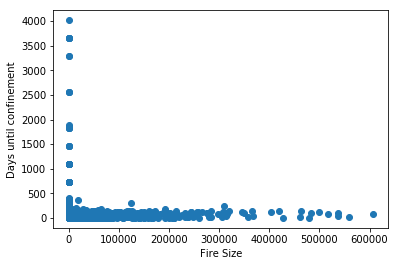

In [15]:
contained = ~np.isnan(df.DAYS_TO_CONTAINMENT)
_ = plt.scatter(df.FIRE_SIZE[contained], df.DAYS_TO_CONTAINMENT[contained])
_ = plt.xlabel('Fire Size')
_ = plt.ylabel('Days until confinement')

In [16]:
long_fires = df.DAYS_TO_CONTAINMENT >= 365
cross_year = df.DISCOVERY_DOY > df.CONT_DOY
columns_of_interest = ['STATE','FIRE_YEAR','FIRE_NAME','COMPLEX_NAME','DISCOVERY_DATE_dt','CONT_DATE_dt',
                       'DAYS_TO_CONTAINMENT','FIRE_SIZE','DISCOVERY_DOY','CONT_DOY']

In [17]:
df.loc[long_fires, columns_of_interest].sort_values('DAYS_TO_CONTAINMENT', ascending = False)

,STATE,FIRE_YEAR,FIRE_NAME,COMPLEX_NAME,DISCOVERY_DATE_dt,CONT_DATE_dt,DAYS_TO_CONTAINMENT,FIRE_SIZE,DISCOVERY_DOY,CONT_DOY
1146209,OR,1998,TIMBER RD #2,None,1998-09-12,2009-09-12,4018.0,0.01,255,255.0
362655,CA,1999,COCHARAN,None,1999-07-11,2009-07-11,3653.0,0.50,192,192.0
362642,CA,1999,TORRES,None,1999-08-11,2009-08-11,3653.0,0.10,223,223.0
362576,CA,1999,LUDINGTON,None,1999-06-16,2009-06-16,3653.0,0.50,167,167.0
362492,CA,1999,FARRIS,None,1999-07-19,2009-07-19,3653.0,0.50,200,200.0
748653,OR,1997,SURGE,None,1997-08-10,2007-08-10,3652.0,0.10,222,222.0
1351259,NY,2000,None,None,2000-03-21,2009-03-21,3287.0,0.10,81,80.0
1317621,WV,2001,ON BIG MT. TOWER RD,None,2001-05-14,2010-05-14,3287.0,4.00,134,134.0
1363058,VA,1995,None,None,1995-03-12,2002-03-13,2558.0,1.00,71,72.0
1363390,VA,1995,None,None,1995-04-07,2002-04-07,2557.0,1.00,97,97.0


Looks like a lot of mis-coding dates!  Most of the supposedly "longest" fires have the containment date the same day of the year (or 1 later) but in a later year. As a spot check, I looked up the "SIXTEEN COMPLEX" fire and it was indeed contained in a few days, not a year and a few days.

In [18]:
(df.CONT_DOY - df.DISCOVERY_DOY).describe()

count    988934.000000
mean          1.090041
std           8.867567
min        -365.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         364.000000
dtype: float64

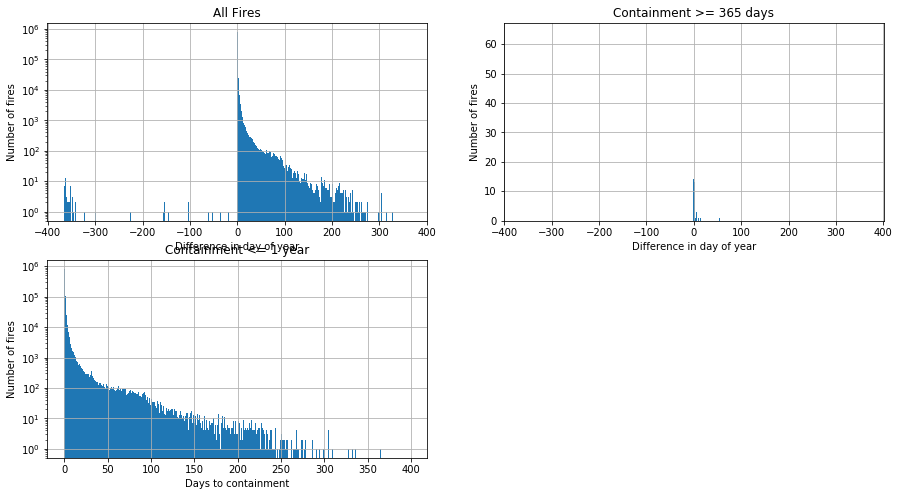

In [19]:
_ = plt.figure(figsize = [15,8])

_ = plt.subplot(2,2,1)
_ = (df.CONT_DOY - df.DISCOVERY_DOY).hist(bins = list(range(-365,366,1)), log = True)
_ = plt.title('All Fires')
_ = plt.xlabel('Difference in day of year')
_ = plt.ylabel('Number of fires')

_ = plt.subplot(2,2,2)
_ = (df.loc[long_fires, 'CONT_DOY'] - df.loc[long_fires, 'DISCOVERY_DOY']).hist(bins = list(range(-365,366,1)), log = False)
_ = plt.title('Containment >= 365 days')
_ = plt.xlabel('Difference in day of year')
_ = plt.ylabel('Number of fires')

_ = plt.subplot(2,2,3)
_ = (df.CONT_DOY - df.DISCOVERY_DOY).hist(bins = list(range(400)), log = True)
_ = plt.title('Containment <= 1 year')
_ = plt.xlabel('Days to containment')
_ = plt.ylabel('Number of fires')


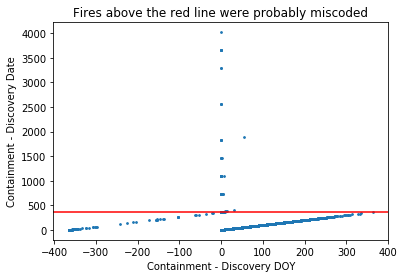

In [20]:
_ = plt.scatter((df.CONT_DOY - df.DISCOVERY_DOY), df.DAYS_TO_CONTAINMENT, s = 3)
_ = plt.xlabel('Containment - Discovery DOY')
_ = plt.ylabel('Containment - Discovery Date')
_ = plt.axhline(364, c = 'r')
_ = plt.title('Fires above the red line were probably miscoded')

In [21]:
# Check for mis-entering discovery date
df.loc[~(df.FIRE_YEAR == [d.year for d in df.DISCOVERY_DATE_dt]), columns_of_interest]

,STATE,FIRE_YEAR,FIRE_NAME,COMPLEX_NAME,DISCOVERY_DATE_dt,CONT_DATE_dt,DAYS_TO_CONTAINMENT,FIRE_SIZE,DISCOVERY_DOY,CONT_DOY
1145576,OR,1993,BONE,None,1994-07-19,1994-07-19,0.0,0.01,200,200.0
1145579,OR,1993,LITTLE POND,None,1994-07-24,1994-07-25,1.0,0.01,205,206.0
1145588,OR,1993,TRASK GRASS,None,1994-03-26,1994-03-26,0.0,1.00,85,85.0
1146542,OR,2010,INC. 253,None,2009-10-10,2010-06-29,262.0,0.10,283,180.0


In [22]:
def correct_cont_days(row):
    # Calculate days to containment assuming no fires burned for a year or more
    if np.isnan(row.CONT_DATE):
        # if containment date is not given
        return np.nan
    
    if (row.CONT_DATE_dt.year == row.DISCOVERY_DATE_dt.year):
        # I know from exploring the data that the containment date is never entered as earlier than the discovery date.
        # There are 4 cases when the year of the discovery date is different from the FIRE_YEAR, but not in a way
        # that appears to cause errors in the containment time.
        # so if the discovery date and containment date are the from the same year, one can just subtract
        assert ((row.CONT_DATE - row.DISCOVERY_DATE) == (row.CONT_DOY - row.DISCOVERY_DOY))
        return row.CONT_DOY - row.DISCOVERY_DOY
    
    # Using the day of the year is a problem if one year is from a leap year and the other isn't
    # e.g. March 1 is the 60th day of 2003 and the 61st day of 2004. So if someone mis-typed 2004 for 2003,
    # containment days would look like either 366 or 1 when it's most likely supposed to be 0.
    leap_year_start = pd.DatetimeIndex(['%d-01-01' %row.DISCOVERY_DATE_dt.year]).is_leap_year[0]
    leap_year_end = pd.DatetimeIndex(['%d-01-01' %row.CONT_DATE_dt.year]).is_leap_year[0]
    days_in_year = 365 + leap_year_start
    
    if (row.CONT_DATE - row.DISCOVERY_DATE) < 365:
        return row.CONT_DATE - row.DISCOVERY_DATE
    
    if (leap_year_start == leap_year_end):
        if row.CONT_DOY >= row.DISCOVERY_DOY:
            return row.CONT_DOY - row.DISCOVERY_DOY
        else:
            # Cross year boundary
            return days_in_year + row.CONT_DOY - row.DISCOVERY_DOY
        
    # Ok, so now we're only dealing with times where the year is probably wrong AND one of them is a leap year
    start_before_leap = (row.DISCOVERY_DATE_dt <= datetime.date(row.DISCOVERY_DATE_dt.year, 2, 28))
    end_before_leap = (row.CONT_DATE_dt <= datetime.date(row.CONT_DATE_dt.year, 2, 28))
    
    if start_before_leap:
        if end_before_leap:
            extra_day = 0
        else:
            if leap_year_start:
                extra_day = 0
            else:
                extra_day = -1
    else:
        if end_before_leap:
            # This one crosses a year boundary and is more complicated - I'm not sure it ever happens, though
            print('Problem?',str(row.DISCOVERY_DATE_dt), str(row.CONT_DATE_dt))
            if leap_year_start:
                extra_day = 365
            else:
                extra_day = 366
        else:
            if leap_year_start:
                extra_day = 1
            else:
                extra_day = -1
    return row.CONT_DOY - row.DISCOVERY_DOY + extra_day

In [23]:
df.DAYS_TO_CONTAINMENT = df.apply(correct_cont_days, axis=1)

In [24]:
df[columns_of_interest].sort_values('DAYS_TO_CONTAINMENT', ascending = False).head(10)

,STATE,FIRE_YEAR,FIRE_NAME,COMPLEX_NAME,DISCOVERY_DATE_dt,CONT_DATE_dt,DAYS_TO_CONTAINMENT,FIRE_SIZE,DISCOVERY_DOY,CONT_DOY
1732846,ND,2014,GLACIER 15,None,2014-10-01,2015-09-30,364.0,0.1,274,273.0
1732847,ND,2014,COAL VEIN 15,None,2014-10-01,2015-09-30,364.0,0.5,274,273.0
230540,NM,1995,COAL,None,1995-01-01,1995-12-31,364.0,1.0,1,365.0
1732845,ND,2014,OXBOW OVERLOOK 15,None,2014-10-01,2015-09-30,364.0,0.1,274,273.0
1286189,WY,2010,SHEEP CREEK,None,2010-07-23,2011-07-22,364.0,280.0,204,203.0
1286223,WY,2010,None,None,2010-07-18,2011-06-29,346.0,0.1,199,180.0
1286247,WY,2010,IR -11-863,None,2010-07-17,2011-06-25,343.0,1.0,198,176.0
318059,CA,2000,SOULIER,None,2000-01-10,2000-12-10,335.0,0.2,10,345.0
242779,WV,1993,THURMOND02,None,1993-02-02,1993-12-31,332.0,0.1,33,365.0
1286213,WY,2010,SOUTH PENNOCK MTN,None,2010-10-03,2011-08-28,329.0,326.0,276,240.0


Some of these fire durations still look suspicious, especially the 364-day ones.  Especially since they're small.

In [25]:
df.loc[long_fires,columns_of_interest].sort_values('DAYS_TO_CONTAINMENT', ascending = False)

,STATE,FIRE_YEAR,FIRE_NAME,COMPLEX_NAME,DISCOVERY_DATE_dt,CONT_DATE_dt,DAYS_TO_CONTAINMENT,FIRE_SIZE,DISCOVERY_DOY,CONT_DOY
356156,CA,2000,BUENAVISTA,None,2000-08-07,2005-10-01,55.0,120.00,220,274.0
1782787,NV,2014,MONTE CARLO,None,2014-04-13,2015-05-15,32.0,0.10,103,135.0
1286275,WY,2010,WILDWOOD,None,2010-08-29,2011-09-11,13.0,48.20,241,254.0
1333890,NY,2003,None,None,2003-03-28,2004-04-10,13.0,0.10,87,101.0
365024,IN,2001,2100 CENTE,None,2001-04-05,2002-04-15,10.0,25.00,95,105.0
1286206,WY,2010,ADON ROAD,None,2010-08-22,2011-08-31,9.0,18.00,234,243.0
298607,CA,2004,AVENUE,None,2004-01-23,2005-01-31,8.0,0.10,23,31.0
1063028,CA,2005,FOOT,None,2005-07-06,2006-07-12,6.0,40.00,187,193.0
1286202,WY,2010,None,None,2010-08-19,2011-08-25,6.0,453.00,231,237.0
1572579,CA,2012,SIXTEEN COMPLEX,SIXTEEN COMPLEX,2012-09-04,2013-09-10,6.0,17944.00,248,253.0


In [26]:
corrected = [~((c - d) == t) for d, c, t in zip(df.DISCOVERY_DATE, df.CONT_DATE, df.DAYS_TO_CONTAINMENT)]

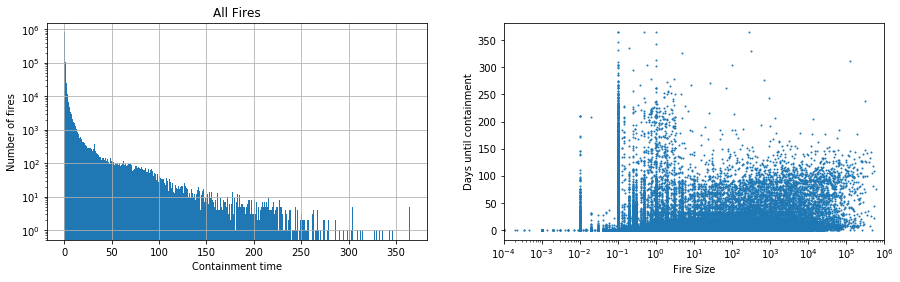

In [33]:
_ = plt.figure(figsize = [15,4])

_ = plt.subplot(1,2,1)
_ = df.DAYS_TO_CONTAINMENT.hist(bins = list(range(366)), log = True)
_ = plt.title('All Fires')
_ = plt.xlabel('Containment time')
_ = plt.ylabel('Number of fires')

_ = plt.subplot(1,2,2)
_ = plt.scatter(df.FIRE_SIZE[contained], df.DAYS_TO_CONTAINMENT[contained], s = 1)
_ = plt.xlabel('Fire Size')
_ = plt.ylabel('Days until containment')
_ = plt.xscale('log')
_ = plt.xlim([10**(-4),10**6])

Some thoughts going forward - am I at all interested in tiny fires?  So many fires are small including many with "suspicious" data.

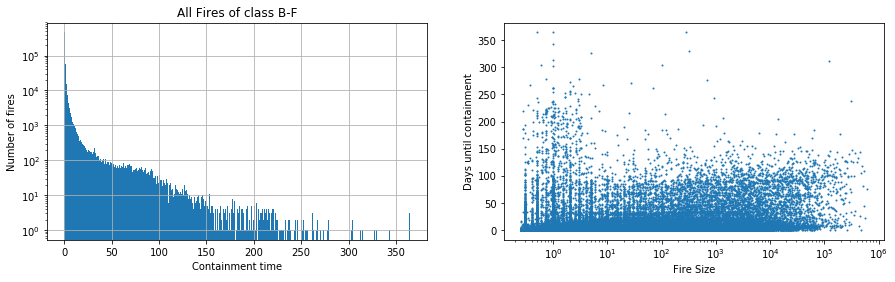

In [28]:
_ = plt.figure(figsize = [15,4])

_ = plt.subplot(1,2,1)
_ = df.loc[df.FIRE_SIZE_CLASS != 'A', 'DAYS_TO_CONTAINMENT'].hist(bins = list(range(366)), log = True)
_ = plt.title('All Fires of class B-F')
_ = plt.xlabel('Containment time')
_ = plt.ylabel('Number of fires')

_ = plt.subplot(1,2,2)
_ = plt.scatter(df.FIRE_SIZE[contained & (df.FIRE_SIZE_CLASS != 'A')], 
                df.DAYS_TO_CONTAINMENT[contained & (df.FIRE_SIZE_CLASS != 'A')], s = 1)
_ = plt.xlabel('Fire Size')
_ = plt.ylabel('Days until containment')
_ = plt.xscale('log')

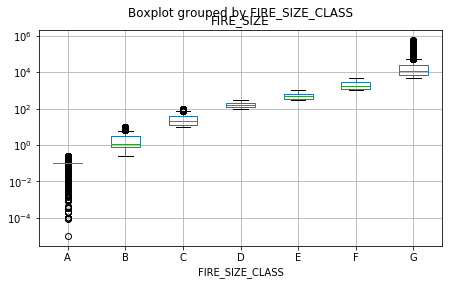

In [32]:
_ = df.boxplot(column = 'FIRE_SIZE', by = 'FIRE_SIZE_CLASS', figsize = (7, 7))
_ = plt.yscale('log')

In [39]:
# What columns are in the other tables?
for table_name in table_names:
    if table_name == 'Fires':
        continue
    t = pd.read_sql_query('select * from %s' %table_name, db)
    print('TABLE:', table_name)
    print(t.info(null_counts = True))
    print()
    print(t.head())
    print()
    print()

TABLE: spatial_ref_sys
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4924 entries, 0 to 4923
Data columns (total 6 columns):
srid            4924 non-null int64
auth_name       4924 non-null object
auth_srid       4924 non-null int64
ref_sys_name    4924 non-null object
proj4text       4924 non-null object
srtext          4924 non-null object
dtypes: int64(2), object(4)
memory usage: 230.9+ KB
None

   srid auth_name  auth_srid                              ref_sys_name  \
0    -1      NONE         -1                     Undefined - Cartesian   
1     0      NONE          0           Undefined - Geographic Long/Lat   
2  2000      epsg       2000  Anguilla 1957 / British West Indies Grid   
3  2001      epsg       2001   Antigua 1943 / British West Indies Grid   
4  2002      epsg       2002  Dominica 1945 / British West Indies Grid   

                                           proj4text  \
0                                                      
1                                   

DatabaseError: Execution failed on sql 'select * from SpatialIndex': no such module: VirtualSpatialIndex

In [44]:
t = pd.read_sql_query('select * from KNN', db)
print('TABLE:', 'KNN')
print(t.info(null_counts = True))
print()
print(t.head())

DatabaseError: Execution failed on sql 'select * from KNN': no such module: VirtualKNN